In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\suhai\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
df=pd.read_csv('comments (2).csv')

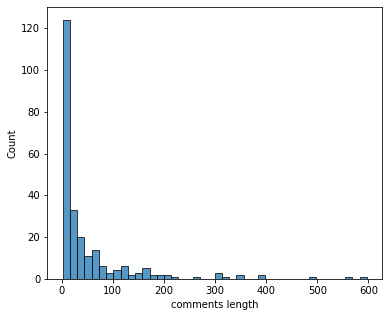

In [32]:
plt.figure(figsize=(6,5))
sns.histplot(data=df['comments'].str.len())
plt.xlabel('comments length')
plt.ylabel('Count')

plt.savefig('Commentslen24.jpg')

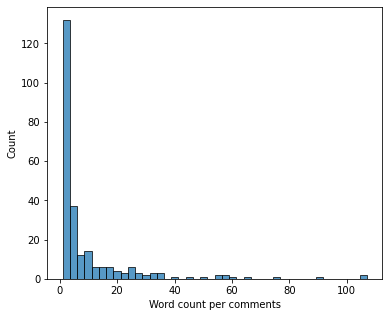

In [33]:
plt.figure(figsize=(6,5))
sns.histplot(data=df['comments'].apply(lambda x: len(x.split())))
plt.xlabel('Word count per comments')
plt.savefig('Commentswords24.jpg')

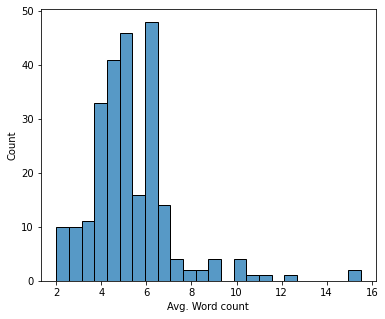

In [34]:
plt.figure(figsize=(6,5))
sns.histplot(data=df['comments'].str.split().apply(lambda x:[ len(i) for i in x]).map(lambda x:np.mean(x)))
plt.xlabel('Avg. Word count')
plt.savefig('avgCommentswords24.jpg')

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suhai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
from collections import defaultdict
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

In [36]:
corpus=[]
new=df['comments'].str.split().values.tolist()
corpus=[w for word in new for w in word ]
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

In [37]:
item=sorted(dic.items(),key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*item)

In [38]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    cv=CountVectorizer(ngram_range=(n,n)).fit(corpus)
    BoW=cv.transform(corpus)
    sum_of_words=BoW.sum(axis=0)
    word_freq=[(word,sum_of_words[0,index]) for word,index in cv.vocabulary_.items()]
    word_freq=sorted(word_freq,key=lambda x:x[1],reverse=True)
    return word_freq[:10]

In [39]:
!pip install wordcloud

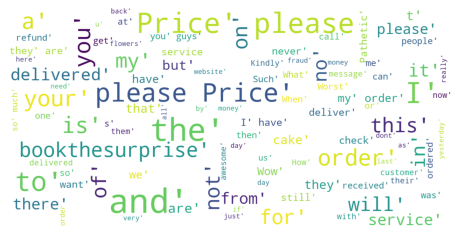

In [40]:
from wordcloud import WordCloud
def WCgenerator(data):
    cloud=WordCloud(background_color='white',stopwords=stop,max_words=100,
            max_font_size=30,
            scale=3,
            random_state=1)

    wc=cloud.generate(str(data))
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(wc)
    plt.savefig('WordCloudIG.jpg')
    
    
WCgenerator(corpus)

In [19]:
from nltk.sentiment import SentimentIntensityAnalyzer
import operator
sia = SentimentIntensityAnalyzer()
df["sentiment_score"] = df["comments"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["sentiment"] = np.select([df["sentiment_score"] < 0, df["sentiment_score"] == 0, df["sentiment_score"] > 0],
                           ['negative', 'neutral', 'positive'])

C:\Users\suhai\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



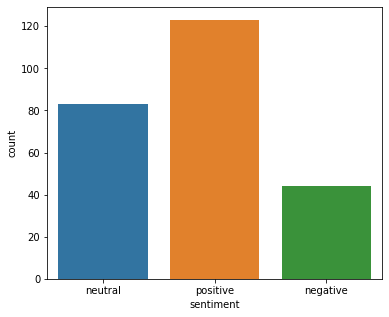

In [41]:
plt.figure(figsize=(6,5))
sns.countplot(df['sentiment'])
plt.savefig('IGsentiment24.jpg')

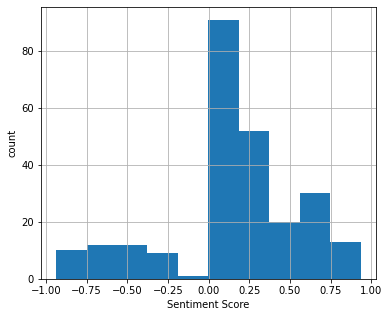

In [42]:
plt.figure(figsize=(6,5))
df.sentiment_score.hist()
plt.xlabel('Sentiment Score')
plt.ylabel('count')
plt.savefig('IGsentimentscore.jpg')

In [22]:
!pip install spacy

In [23]:
!python -m spacy download en_core_web_sm

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\suhai\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 173, in _main
    status = self.run(options, args)
  File "C:\Users\suhai\anaconda3\lib\site-packages\pip\_internal\cli\req_command.py", line 203, in wrapper
    return func(self, options, args)
  File "C:\Users\suhai\anaconda3\lib\site-packages\pip\_internal\commands\install.py", line 315, in run
    requirement_set = resolver.resolve(
  File "C:\Users\suhai\anaconda3\lib\site-packages\pip\_internal\resolution\resolvelib\resolver.py", line 75, in resolve
    collected = self.factory.collect_root_requirements(root_reqs)
  File "C:\Users\suhai\anaconda3\lib\site-packages\pip\_internal\resolution\resolvelib\factory.py", line 471, in collect_root_requirements
    req = self._make_requirement_from_install_req(
  File "C:\Users\suhai\anaconda3\lib\site-packages\pip\_internal\resolution\resolvelib\factory.py", line 433, in _make_requirement_from_ins

In [43]:
import spacy
from collections import Counter
nlp = spacy.load("en_core_web_sm")

def NER(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent=df['comments'].apply(lambda x : NER(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

In [44]:
x,y=map(list,zip(*count))

C:\Users\suhai\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



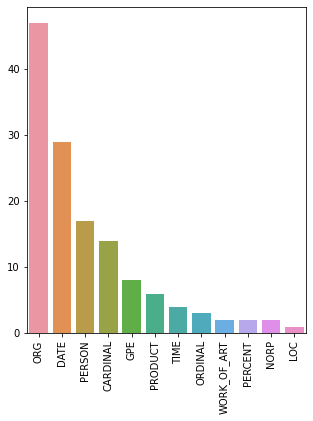

In [45]:
plt.figure(figsize=(5,6))
sns.barplot(x,y)
plt.xticks(rotation=90)
plt.savefig('IGtopic24.jpg')

In [48]:
import nltk
import gensim
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['comments']:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus=preprocess_news(df)

dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\suhai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\suhai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[(0,
  '0.029*"order" + 0.022*"bookthesurprise" + 0.018*"..." + 0.012*"customer" + 0.012*"service" + 0.012*"Wow" + 0.010*"product" + 0.009*"received" + 0.009*"Kindly" + 0.009*"experience"'),
 (1,
  '0.025*"order" + 0.021*"delivered" + 0.018*"service" + 0.017*"cake" + 0.016*"guy" + 0.012*"money" + 0.010*"refund" + 0.010*"customer" + 0.009*"fraud" + 0.009*"day"'),
 (2,
  '0.016*"..." + 0.014*"service" + 0.011*"Merry" + 0.011*"order" + 0.008*"update" + 0.008*"Christmas" + 0.008*"hai" + 0.008*"Can" + 0.008*"find" + 0.008*"What"'),
 (3,
  '0.148*"Price" + 0.122*"please" + 0.010*"‚ù§Ô∏è‚ù§Ô∏è" + 0.008*"Please" + 0.008*"amazing" + 0.008*"Beautiful" + 0.008*"buy" + 0.007*"never" + 0.007*"really" + 0.006*"order"')]

In [30]:
!pip install pyldavis

In [49]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dic)
vis

C:\Users\suhai\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.081522 -0.007562       1        1  35.925375
1     -0.059619 -0.098983       2        1  31.317547
2     -0.037026  0.118500       3        1  16.547504
3      0.178167 -0.011955       4        1  16.209574, topic_info=          Term       Freq      Total Category  logprob  loglift
0        Price  35.000000  35.000000  Default  30.0000  30.0000
11      please  29.000000  29.000000  Default  29.0000  29.0000
1          ...  13.000000  13.000000  Default  28.0000  28.0000
258        guy   8.000000   8.000000  Default  27.0000  27.0000
72        cake   9.000000   9.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
19     deliver   0.695415   6.188514   Topic4  -5.8209  -0.3664
192        Now   0.688628   1.955645   Topic4  -5.8307   0.7758
167     showed   0.687708   1.955981   Topic4  -5.8321   0.7743
171  chocolate   0.687483   1.956063   Topic4  -5.8324   0.7739
589      tried   0.687256   1.956129   Topic4  -5.8327   0.7736

[228 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         1  0.672899      ...
1         3  0.299066      ...
32        1  0.964755     ....
61        1  0.921089  Amazing
47        2  0.692618      And
...     ...       ...      ...
406       1  0.921103      yet
355       4  0.698298     ‚ù§Ô∏è‚ù§Ô∏è
35        1  0.920990      üëåüèªüòç
17        4  0.566765      üòç‚ù§Ô∏è
90        3  0.528859      üòçüòçüòç

[269 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])